# ESGF Virtual Aggregation - Global Surface Air Temperature changes in future scenarios

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products, which has been adapted to work with the ESGF Virtual Aggregation. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

**E. Cimadevilla** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook computes Global Surface Air Temperature (GSAT) changes relative to the 1995–2014 and 1850–1900 averages, according to CMIP6 climate models.

This notebook works with data available in the ESGF, which is accessed in a **remote data access** fashion through virtual aggregations provided by the [ESGF Virtual Aggregation](https://doi.org/10.5194/gmd-2024-120).

In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## 1. Data loading

To locate the data in which we are interested, we use the CSV inventory of the ESGF Virtual Aggregation. We will analyze the inventory using standard Pandas functionality. The data will be loaded in a remote data access fashion via OPeNDAP provided by a THREDDS Data Server.

The versions of the ESGF datasets in which we are interested are available in the `atlas-tas.csv` file provided in this same directory. These versions were extracted from the [IPCC-WGI/Atlas GitHub repository](https://raw.githack.com/IPCC-WG1/Atlas/devel/data-sources/CMIP6/CMIP6.html).

In [3]:
esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")
atlas_ipcc_catalog = pd.read_csv("atlas-tas.csv")
model_runs = atlas_ipcc_catalog[["model", "member"]].set_index("model").to_dict()["member"]

/tmp/ipykernel_2571171/3325839039.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")


The following function manages the locations of the datasets from the ESGF Virtual Aggregation that we are interested in. Since some versions are no longer available on the ESGF—having been replaced by newer versions—not all of the original datasets will be loaded.

In [4]:
def find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, experiment):
    ignored_models = [
        "EC-Earth3", # missing file at CEDA
        "EC-Earth3-Veg", # replica unavailable
        "MIROC-ES2L", # no replica seems to work
        "BCC-CSM2-MR", # no replica seems to work
        "FGOALS-g3", # time series split across different versions
        "KACE-1-0-G", # unavailable
        "NESM3", # bad time coord

        # not available at IA
        "KIOST-ESM",
        "MPI-ESM-1-2-HAM",
        # not available later for Pangeo
        "ACCESS-CM2",
        "ACCESS-ESM1-5",
    ]
    
    preferred_replicas = {
        "historical": {
            "HadGEM3-GC31-LL": "", # esgf-data04.diasjp.net netcdf-java error, ...
            "UKESM1-0-LL": "",
        },
        "ssp126": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
        "ssp245": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
        "ssp370": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
        "ssp585": {
            "HadGEM3-GC31-LL": "",
            "UKESM1-0-LL": "",
        },
    }
    
    esgf_va_model_runs = []
    for model in model_runs:
        if model in ignored_models:
            continue
    
        esgf_va_subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'tas' & experiment == '{experiment}'").set_index(["project", "model", "experiment", "version"]).drop(["variable"], axis=1)
        atlas_ipcc_subset = atlas_ipcc_catalog.drop(["variable"], axis=1)
        
        subset = esgf_va_subset.join(atlas_ipcc_subset.set_index(["project", "model", "experiment", "version"]), on=["project", "model", "experiment", "version"], how="inner")
        if len(subset) > 0:
            # Choose the preferred replica or default to esgf.ceda.ac.uk
            if model in preferred_replicas[experiment]:
                replica = preferred_replicas[experiment][model]
            else:
                replica = "esgf.ceda.ac.uk"
    
            # Probe if the required model member is included in the esgf-va
            print(model)
            subset.to_csv("subset.csv", index=False)
            url = subset[subset["replica"] == replica]["location"].iloc[0]
            print(url)
            ds = xarray.open_dataset(
                url,
                decode_times=False,
                drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"])
    
            if model_runs[model].encode("ascii") in ds["variant_label"].values:
                record = {"url": url, "model_run": model + "_" + model_runs[model]}
                esgf_va_model_runs.append(record)

    return pd.DataFrame.from_records(esgf_va_model_runs)

Locate the datasets for both the historical and future scenarios.

In [5]:
ssp126_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp126").set_index("model_run").rename({"url": "ssp126"}, axis=1)
ssp245_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp245").set_index("model_run").rename({"url": "ssp245"}, axis=1)
ssp370_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp370").set_index("model_run").rename({"url": "ssp370"}, axis=1)
ssp585_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp585").set_index("model_run").rename({"url": "ssp585"}, axis=1)
historical_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "historical").set_index("model_run").rename({"url": "historical"}, axis=1)

AWI-CM-1-1-MR
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp126_day_gn_v20190529/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp126_day_tas_gn_v20190529.ncml
CAMS-CSM1-0
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp126_day_gn_v20191106/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp126_day_tas_gn_v20191106.ncml
CMCC-CM2-SR5
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp126_day_gn_v20200717/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp126_day_tas_gn_v20200717.ncml
CNRM-CM6-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_day_tas_gr_v20190219.ncml
CNRM-ESM2-1
http

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


CMCC-CM2-SR5
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_gn_v20200622/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_tas_gn_v20200622.ncml
CNRM-CM6-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_tas_gr_v20190219.ncml
CNRM-CM6-1-HR
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_gr_v20191202/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_tas_gr_v20191202.ncml
CNRM-ESM2-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_tas_

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


CMCC-CM2-SR5
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_gn_v20200616/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_tas_gn_v20200616.ncml
CNRM-CM6-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_gr_v20180917/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_tas_gr_v20180917.ncml
CNRM-CM6-1-HR
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_tas_gr_v20191021.ncml
CNRM-ESM2-1
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_gr_v20181206/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_tas_gr_v20181206.ncml
GFDL-CM4
https://hub.ipcc.ifca.es/

We now create a DataFrame containing all the available datasets.

In [6]:
df = historical_model_runs.join(
    ssp585_model_runs).join(
    ssp126_model_runs).join(
    ssp245_model_runs).join(
    ssp370_model_runs)
df

,historical,ssp585,ssp126,ssp245,ssp370
model_run,,,,,
AWI-CM-1-1-MR_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CAMS-CSM1-0_r2i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CanESM5_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CESM2-WACCM_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CMCC-CM2-SR5_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CNRM-CM6-1_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
CNRM-CM6-1-HR_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN
CNRM-ESM2-1_r1i1p1f2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...
GFDL-CM4_r1i1p1f1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN,NaN,NaN,NaN


Show the number of available members for each scenario.

In [7]:
(~df.isna()).sum()

historical    23
ssp585        14
ssp126        12
ssp245         9
ssp370        10
dtype: int64

Load the datasets.

In [8]:
def load_datasets(locations, members, experiment):
    dss = []
    for location in locations:
        if location is np.nan:
            continue
        
        name = location.split("/")[-1]
        model = name.split("_")[3]

        ds = xarray.open_dataset(
            location,
            drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"]).sel(
            variant_label=members[model].encode("ascii"))

        if experiment.startswith("ssp"):
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "20991230"))
            else:
                ds = ds.sel(time=slice("20150101", "20991231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
        dss.append(ds)

    return dss

Open the datasets using [xarray](https://docs.xarray.dev/en/stable/).

In [9]:
historical_dss = load_datasets(df["historical"], model_runs, "historical")
ssp126_dss = load_datasets(df["ssp126"], model_runs, "ssp126")
ssp245_dss = load_datasets(df["ssp245"], model_runs, "ssp245")
ssp370_dss = load_datasets(df["ssp370"], model_runs, "ssp370")
ssp585_dss = load_datasets(df["ssp585"], model_runs, "ssp585")

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/tmp/ipykernel_2571171/2103017150.py:10: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_dataset(
/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Print size of the datasets:

In [10]:
for ds in historical_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

16949.53 MB
11770.51 MB
1882.03 MB
12703.92 MB
12703.71 MB
7533.12 MB
59588.20 MB
7533.12 MB
11909.73 MB
11909.73 MB
6264.84 MB
4149.17 MB
4962.39 MB
4962.39 MB
4733.95 MB
7533.12 MB
16949.53 MB
4237.38 MB
11770.51 MB
3175.93 MB
12703.71 MB
12703.71 MB
6264.84 MB


In [11]:
for ds in ssp126_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
6544.34 MB
3880.75 MB
3880.75 MB
6135.31 MB
2137.44 MB
2438.73 MB
3880.75 MB
8731.69 MB
2182.92 MB
3227.34 MB


In [12]:
for ds in ssp245_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
6544.34 MB
3880.75 MB
2137.44 MB
2438.73 MB
8731.69 MB
6063.67 MB
3227.34 MB


In [13]:
for ds in ssp370_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
6544.34 MB
3880.75 MB
3880.75 MB
2112.31 MB
2438.73 MB
8731.69 MB
6063.67 MB
3227.34 MB


In [14]:
for ds in ssp585_dss:
    print(f'{ds["tas"].size * ds["tas"].dtype.itemsize / 2**20:.2f} MB')

8731.69 MB
6063.67 MB
969.53 MB
6544.34 MB
6544.34 MB
3880.75 MB
30697.34 MB
3880.75 MB
3227.34 MB
2137.44 MB
2438.73 MB
8731.69 MB
1636.08 MB
6544.34 MB


- Historical - 227 GB, Wall time: 1h 59min 6s
- Historical (subset) - 1 hour 1 min 19s
- Scenarios - ~200 GB (all), Wall times:
    - 29min 56s
    - 22min 38s
    - 24min 29s
    - 40min 38s

# Pangeo

In [14]:
pangeo_catalog = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
pangeo_catalog["version"] = pangeo_catalog["version"].astype(str)
pangeo_catalog.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [15]:
def find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, esgf_va_df, experiment):
    pangeo_model_runs = []
    
    for model, run in esgf_va_df.index.str.split("_"):
        # # descomentar cuando ejecute el notebook entero otra vez
        # # añadir a la lista de modelos ignorados al principio
        # if model in ["ACCESS-CM2","ACCESS-ESM1-5", "KIOST-ESM", "MPI-ESM-1-2-HAM"]:
        #     continue
        model_run = "_".join([model, run])
        if model_run not in esgf_va_df.index or (model_run in esgf_va_df.index and esgf_va_df.loc[model_run, experiment] is np.nan):
            continue

        version = atlas_ipcc_catalog.query(f"model == '{model}' & experiment == '{experiment}' & member == '{run}' & variable == 'tas'")["version"].iloc[0][1:]
        subset = pangeo_catalog.query(f"source_id == '{model}' & table_id == 'day' & variable_id == 'tas' & experiment_id == '{experiment}' & member_id == '{run}' & version == '{version}'").set_index(["source_id", "experiment_id", "version"]).drop(["variable_id"], axis=1)

        url = subset["zstore"].iloc[0]
        record = {"url": url, "model_run": model + "_" + model_runs[model]}
        pangeo_model_runs.append(record)

    return pd.DataFrame.from_records(pangeo_model_runs)

In [18]:
ssp126_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "ssp126").set_index("model_run").rename({"url": "ssp126"}, axis=1)
ssp245_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "ssp245").set_index("model_run").rename({"url": "ssp245"}, axis=1)
ssp370_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "ssp370").set_index("model_run").rename({"url": "ssp370"}, axis=1)
ssp585_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "ssp585").set_index("model_run").rename({"url": "ssp585"}, axis=1)
historical_model_runs_pangeo = find_model_runs_pangeo(pangeo_catalog, atlas_ipcc_catalog, model_runs, df, "historical").set_index("model_run").rename({"url": "historical"}, axis=1)

In [20]:
df_pangeo = historical_model_runs_pangeo.join(
    ssp126_model_runs_pangeo).join(
    ssp245_model_runs_pangeo).join(
    ssp370_model_runs_pangeo).join(
    ssp585_model_runs_pangeo)
df_pangeo

,historical,ssp126,ssp245,ssp370,ssp585
model_run,,,,,
AWI-CM-1-1-MR_r1i1p1f1,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...,gs://cmip6/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR...
CAMS-CSM1-0_r2i1p1f1,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...,gs://cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/...
CanESM5_r1i1p1f1,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,NaN,NaN,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...
CESM2-WACCM_r1i1p1f1,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,NaN,NaN,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/...
CMCC-CM2-SR5_r1i1p1f1,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...,gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...
CNRM-CM6-1_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
CNRM-CM6-1-HR_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-...,NaN,NaN,NaN,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
CNRM-ESM2-1_r1i1p1f2,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...
GFDL-CM4_r1i1p1f1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,NaN,NaN,NaN


In [26]:
(~df_pangeo.isna()).sum()

historical    23
ssp126        12
ssp245         9
ssp370        10
ssp585        14
dtype: int64

In [27]:
(~df.isna()).sum()

historical    23
ssp585        14
ssp126        12
ssp245         9
ssp370        10
dtype: int64

In [31]:
def load_datasets_pangeo(locations, members, experiment):
    dss = []
    for location in locations:
        if location is np.nan:
            continue

        model = location.split("/")[6]

        ds = xarray.open_zarr(
            location,
            drop_variables=["time_bnds", "lat_bnds", "lon_bnds"])

        if experiment.startswith("ssp"):
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "21001230"))
            else:
                ds = ds.sel(time=slice("20150101", "21001231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
        dss.append(ds)

    return dss

In [32]:
historical_dss_pangeo = load_datasets_pangeo(df_pangeo["historical"], model_runs, "historical")
ssp126_dss_pangeo = load_datasets_pangeo(df_pangeo["ssp126"], model_runs, "ssp126")
ssp245_dss_pangeo = load_datasets_pangeo(df_pangeo["ssp245"], model_runs, "ssp245")
ssp370_dss_pangeo = load_datasets_pangeo(df_pangeo["ssp370"], model_runs, "ssp370")
ssp585_dss_pangeo = load_datasets_pangeo(df_pangeo["ssp585"], model_runs, "ssp585")

/tmp/ipykernel_2571171/107158250.py:9: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_zarr(


# modulo gsat

In [10]:
from gsat import weighted, unweighted

## Weighted

In [11]:
%%time

mean_hist_1995_2014, mean_hist_1850_1900, mean_hist, mean_ssp126, mean_ssp245, mean_ssp370, mean_ssp585 = weighted(
    8,
    historical_dss, ssp126_dss, ssp245_dss, ssp370_dss, ssp585_dss)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 36min 43s, sys: 58min 42s, total: 1h 35min 25s
Wall time: 4h 57min 26s


In [44]:
m_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))
m_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
m_ssp245 = (mean_ssp245 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
m_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
m_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")

m_hist_18   = (mean_hist   - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))
m_ssp126_18 = (mean_ssp126 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")
m_ssp245_18 = (mean_ssp245 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")
m_ssp370_18 = (mean_ssp370 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")
m_ssp585_18 = (mean_ssp585 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")

q_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))
q_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])
q_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])
q_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

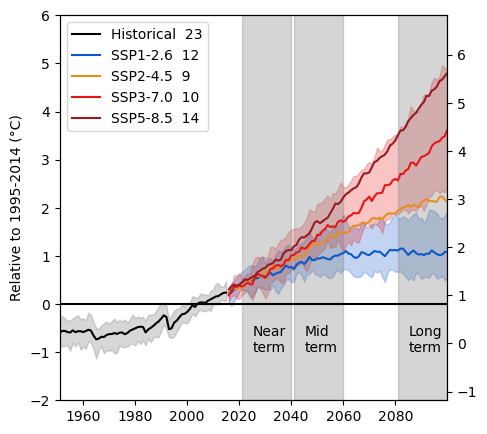

In [51]:
fig, ax = plt.subplots(figsize=(5,5))

ax.fill_between(q_hist.time,
                q_hist.sel(quantile=.05),
                q_hist.sel(quantile=.95),
                color="#616161", alpha=0.25)
ax.fill_between(q_ssp126.time,
                q_ssp126.sel(quantile=.05),
                q_ssp126.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.fill_between(q_ssp370.time,
                q_ssp370.sel(quantile=.05),
                q_ssp370.sel(quantile=.95),
                color="#e81515", alpha=0.25)

ytop = 6
ax.set_ylabel("Relative to 1995-2014 (°C)")
ax.axhline(y=0, color="black")
ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")
ax.fill_between(
    m_ssp126["time"].sel(time=slice("20200101", "20400101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20400101", "20600101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20800101", None)),
    -2, ytop+.82, alpha=.33, color="grey")

ax2 = ax.twinx()
ax2.set_ylim(bottom=-2+.82, top=ytop+.82)
ax.set_ylim([-2, ytop])

ax.plot(m_hist.time, m_hist, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
ax.plot(m_ssp126.time, m_ssp126, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
ax.plot(m_ssp245.time, m_ssp245, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
ax.plot(m_ssp370.time, m_ssp370, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
ax.plot(m_ssp585.time, m_ssp585, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

# ax2.plot(m_hist_18.time, m_hist_18, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
# ax2.plot(m_ssp126_18.time, m_ssp126_18, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
# ax2.plot(m_ssp245_18.time, m_ssp245_18, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
# ax2.plot(m_ssp370_18.time, m_ssp370_18, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
# ax2.plot(m_ssp585_18.time, m_ssp585_18, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

ax.margins(0)
ax2.margins(0)
ax.legend()

## Unweighted

In [11]:
%%time

mean_hist_1995_2014, mean_hist_1850_1900, mean_hist, mean_ssp126, mean_ssp245, mean_ssp370, mean_ssp585 = unweighted(
    8,
    historical_dss, ssp126_dss, ssp245_dss, ssp370_dss, ssp585_dss)

Model_run: AWI-CM-1-1-MR_r1i1p1f1
Model_run: CAMS-CSM1-0_r2i1p1f1
Model_run: CanESM5_r1i1p1f1
Model_run: CESM2-WACCM_r1i1p1f1
Model_run: CMCC-CM2-SR5_r1i1p1f1
Model_run: CNRM-CM6-1_r1i1p1f2
Model_run: CNRM-CM6-1-HR_r1i1p1f2
Model_run: CNRM-ESM2-1_r1i1p1f2
Model_run: GFDL-CM4_r1i1p1f1
Model_run: GFDL-ESM4_r1i1p1f1
Model_run: HadGEM3-GC31-LL_r1i1p1f3
Model_run: IITM-ESM_r1i1p1f1
Model_run: INM-CM4-8_r1i1p1f1
Model_run: INM-CM5-0_r1i1p1f1
Model_run: IPSL-CM6A-LR_r1i1p1f1
Model_run: MIROC6_r1i1p1f1
Model_run: MPI-ESM1-2-HR_r1i1p1f1
Model_run: MPI-ESM1-2-LR_r1i1p1f1
Model_run: MRI-ESM2-0_r1i1p1f1
Model_run: NorESM2-LM_r1i1p1f1
Model_run: NorESM2-MM_r1i1p1f1
Model_run: TaiESM1_r1i1p1f1
Model_run: UKESM1-0-LL_r1i1p1f2
CPU times: user 3min 3s, sys: 6.04 s, total: 3min 9s
Wall time: 4h 40min 39s


In [12]:
m_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))
m_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
m_ssp245 = (mean_ssp245 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
m_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")
m_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().mean("member")

m_hist_18   = (mean_hist   - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member").isel(time=slice(None,-1))
m_ssp126_18 = (mean_ssp126 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")
m_ssp245_18 = (mean_ssp245 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")
m_ssp370_18 = (mean_ssp370 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")
m_ssp585_18 = (mean_ssp585 - mean_hist_1850_1900).resample({"time": "YE"}).mean().mean("member")

q_hist   = (mean_hist   - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"]).isel(time=slice(None,-1))
q_ssp126 = (mean_ssp126 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])
q_ssp370 = (mean_ssp370 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])
q_ssp585 = (mean_ssp585 - mean_hist_1995_2014).resample({"time": "YE"}).mean().quantile([.05, .95], dim=["member"])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23,) + inhomogeneous part.

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.fill_between(q_hist.time,
                q_hist.sel(quantile=.05),
                q_hist.sel(quantile=.95),
                color="#616161", alpha=0.25)
ax.fill_between(q_ssp126.time,
                q_ssp126.sel(quantile=.05),
                q_ssp126.sel(quantile=.95),
                color="#0e57cc", alpha=0.25)
ax.fill_between(q_ssp370.time,
                q_ssp370.sel(quantile=.05),
                q_ssp370.sel(quantile=.95),
                color="#e81515", alpha=0.25)

ytop = 6
ax.set_ylabel("Relative to 1995-2014 (°C)")
ax.axhline(y=0, color="black")
ax.text(np.datetime64('2024-12-31T00:00:00.000000000'), -1, "Near\nterm")
ax.text(np.datetime64('2044-12-31T00:00:00.000000000'), -1, "Mid\nterm")
ax.text(np.datetime64('2084-12-31T00:00:00.000000000'), -1, "Long\nterm")
ax.fill_between(
    m_ssp126["time"].sel(time=slice("20200101", "20400101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20400101", "20600101")),
    -2, ytop+.82, alpha=.33, color="grey")
ax.fill_between(
     m_ssp126["time"].sel(time=slice("20800101", None)),
    -2, ytop+.82, alpha=.33, color="grey")

ax2 = ax.twinx()
ax2.set_ylim(bottom=-2+.82, top=ytop+.82)
ax.set_ylim([-2, ytop])

ax.plot(m_hist.time, m_hist, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
ax.plot(m_ssp126.time, m_ssp126, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
ax.plot(m_ssp245.time, m_ssp245, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
ax.plot(m_ssp370.time, m_ssp370, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
ax.plot(m_ssp585.time, m_ssp585, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

# ax2.plot(m_hist_18.time, m_hist_18, color="#010101", label=f"Historical  {len(mean_hist['member'])}")
# ax2.plot(m_ssp126_18.time, m_ssp126_18, color="#0e57cc", label=f"SSP1-2.6  {len(mean_ssp126['member'])}")
# ax2.plot(m_ssp245_18.time, m_ssp245_18, color="#e68d26", label=f"SSP2-4.5  {len(mean_ssp245['member'])}")
# ax2.plot(m_ssp370_18.time, m_ssp370_18, color="#e81515", label=f"SSP3-7.0  {len(mean_ssp370['member'])}")
# ax2.plot(m_ssp585_18.time, m_ssp585_18, color="#9b1a22", label=f"SSP5-8.5  {len(mean_ssp585['member'])}")

ax.margins(0)
ax2.margins(0)
ax.legend()